<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# GARCH Lab

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Load the data and log-transform `tb1`

In [2]:
df = pd.read_csv('datasets/Mishkin.csv')
df['log_tb1'] = np.log(df['tb1'])
df.head()

,pai1,pai3,tb1,tb3,cpi,log_tb1
0,-3.552289,1.129370,1.100854,1.129406,23.5,0.096086
1,5.247540,4.001566,1.125513,1.137254,23.6,0.118239
2,1.692860,4.492160,1.115715,1.142319,23.6,0.109495
3,5.064298,7.817513,1.146380,1.177902,23.7,0.136609
4,6.719322,9.433580,1.158520,1.167777,23.8,0.147143


### Visualize the time series. Would differencing be useful?

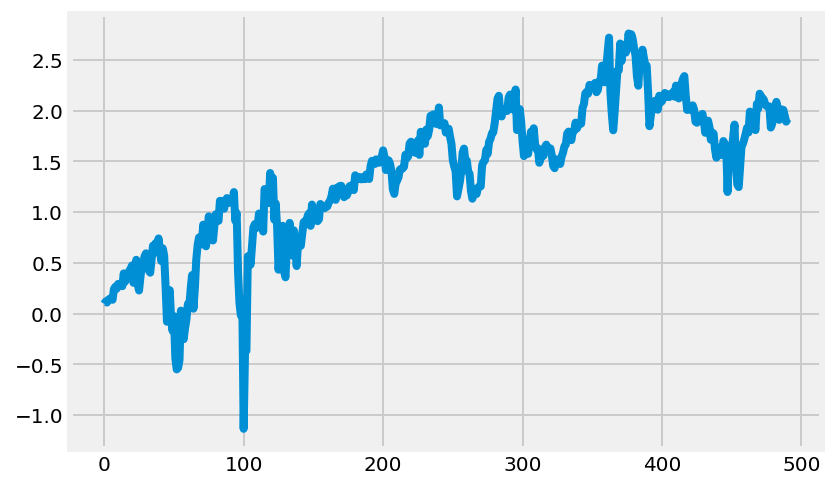

In [3]:
df.log_tb1.plot();

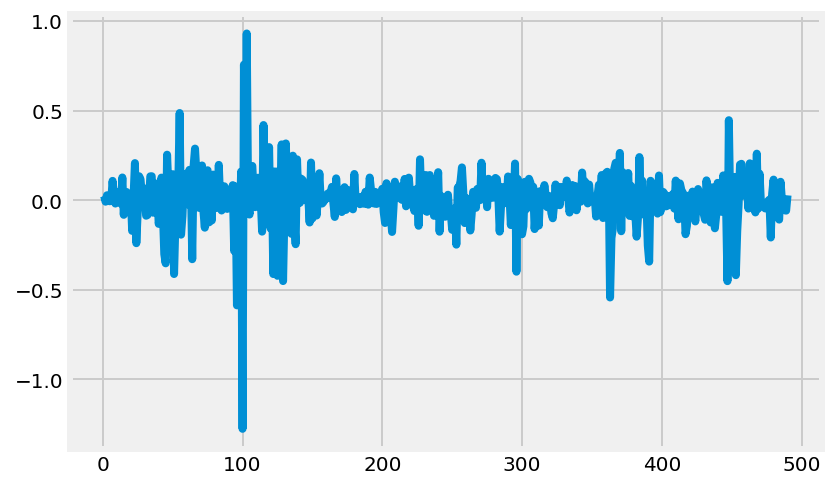

In [4]:
df.log_tb1.diff().plot();

### Fit a GARCH model

In [5]:
from arch import arch_model

In [6]:
data = df[['log_tb1']].diff()[1:]

In [7]:
am = arch_model(data, mean='AR', lags=3, vol='GARCH', p=3, q=3)
res = am.fit(update_freq=7)
res.summary()

Iteration:      7,   Func. Count:    103,   Neg. LLF: -344.9109984265248
Iteration:     14,   Func. Count:    202,   Neg. LLF: -350.28025569517683
Iteration:     21,   Func. Count:    295,   Neg. LLF: -350.9768833045147
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -350.97689458965914
            Iterations: 22
            Function evaluations: 309
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                log_tb1   R-squared:                       0.013
Mean Model:                        AR   Adj. R-squared:                  0.007
Vol Model:                      GARCH   Log-Likelihood:                350.977
Distribution:                  Normal   AIC:                          -679.954
Method:            Maximum Likelihood   BIC:                          -633.883
                                        No. Observations:                  487
Date:                Fri, Aug 24 2018   Df Residuals:                      476
Time:                        10:52:48   Df Model:                           11
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      8.0316e-03  5.479e-03      1.466      0.143 [-2.706e-03,1.877e-02]
log_tb1[1]    -0.1605  6.441e-02     -2.491  1.272e-02   [ -0.287,-3.423e-02]
log_tb1[2]    -0.1137  5.654e-02     -2.011  4.429e-02   [ -0.225,-2.905e-03]
log_tb1[3]     0.0187  6.449e-02      0.291      0.771      [ -0.108,  0.145]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.6306e-03  1.757e-03      1.497      0.134 [-8.130e-04,6.074e-03]
alpha[1]       0.2713      0.107      2.529  1.145e-02    [6.101e-02,  0.482]
alpha[2]       0.0492      0.181      0.272      0.786      [ -0.305,  0.404]
alpha[3]       0.2122      0.401      0.529      0.597      [ -0.574,  0.998]
beta[1]        0.4014      0.368      1.091      0.275      [ -0.319,  1.122]
beta[2]        0.0000      0.718      0.000      1.000      [ -1.406,  1.406]
beta[3]    2.4853e-12      0.538  4.620e-12      1.000      [ -1.054,  1.054]
=============================================================================

Covariance estimator: robust
"""

### Obtain the model score

In [8]:
res.rsquared

0.012900205837121592

### Look at the distribution of the residuals

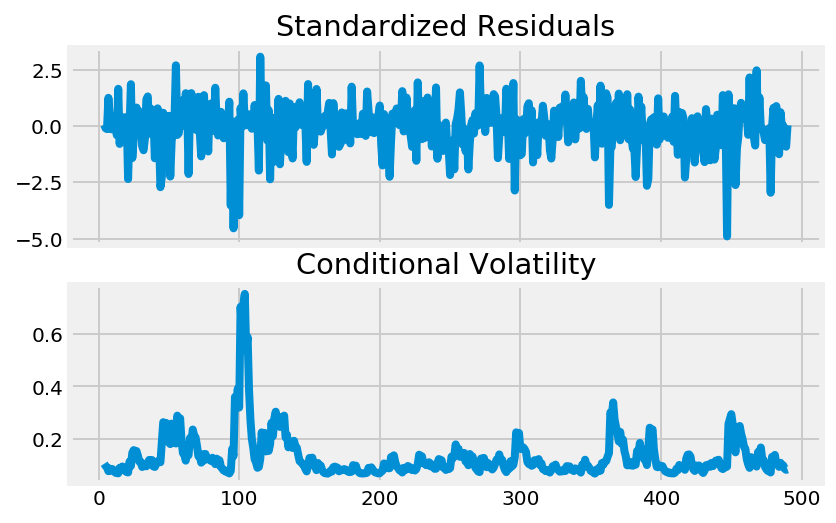

In [9]:
res.plot();

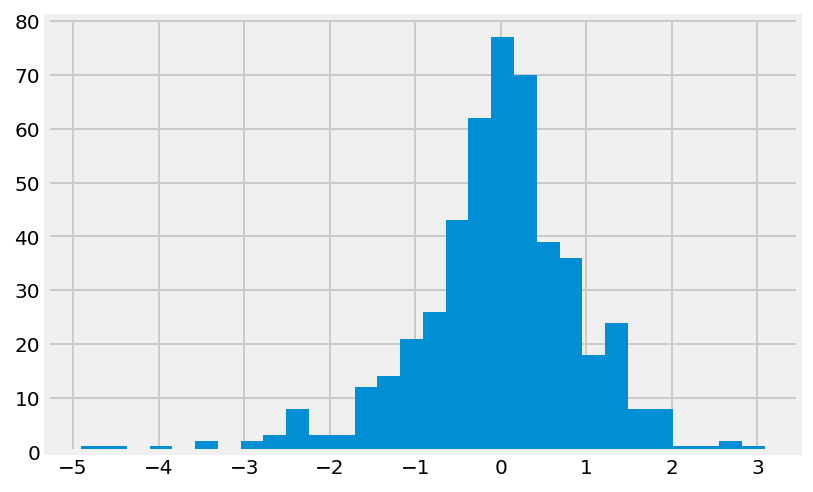

In [10]:
resid_standardized = (res.resid/res.conditional_volatility)
resid_standardized.hist(bins=30);

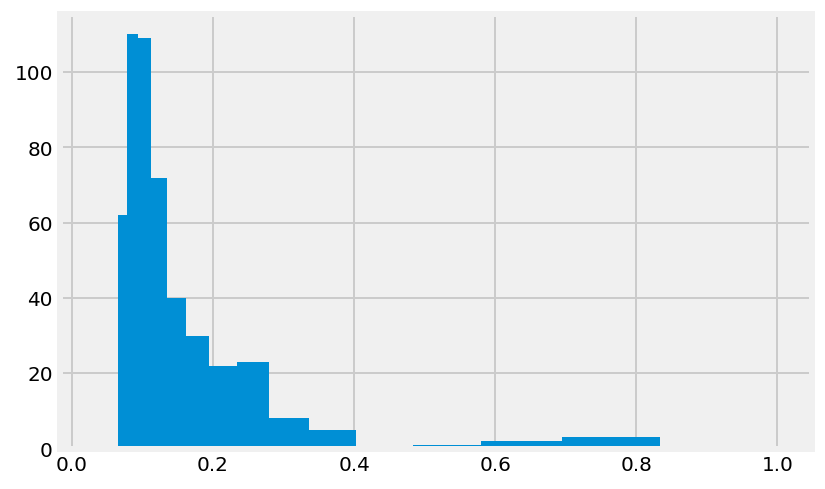

In [11]:
res.conditional_volatility.hist(bins=np.logspace(-1.5,0,20));

### Obtain the model forecasts and plot

In [12]:
forecasts = res.forecast(horizon=5, start=2)

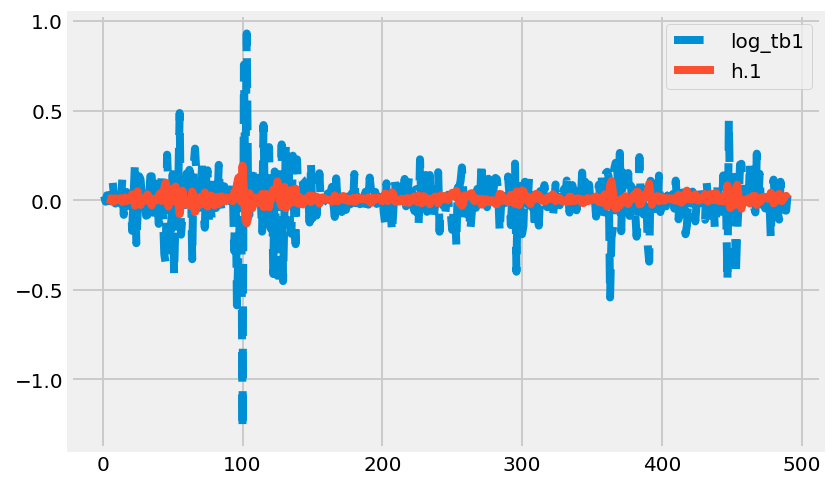

In [13]:
fig, ax = plt.subplots()
data.plot(ax=ax,label='data',ls='--')
forecasts.mean[['h.1']].plot(ax=ax)
ax.legend();

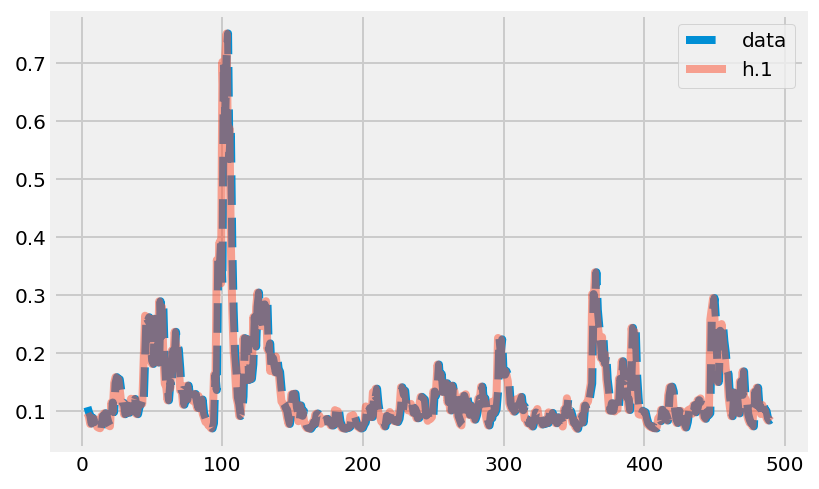

In [14]:
fig, ax = plt.subplots()
res.conditional_volatility.plot(ax=ax,label='data',ls='--')
forecasts.variance[['h.1']].apply(np.sqrt).plot(ax=ax,alpha=0.5)
ax.legend();

### Produce a hedgehog plot for the predicted means and volatilities

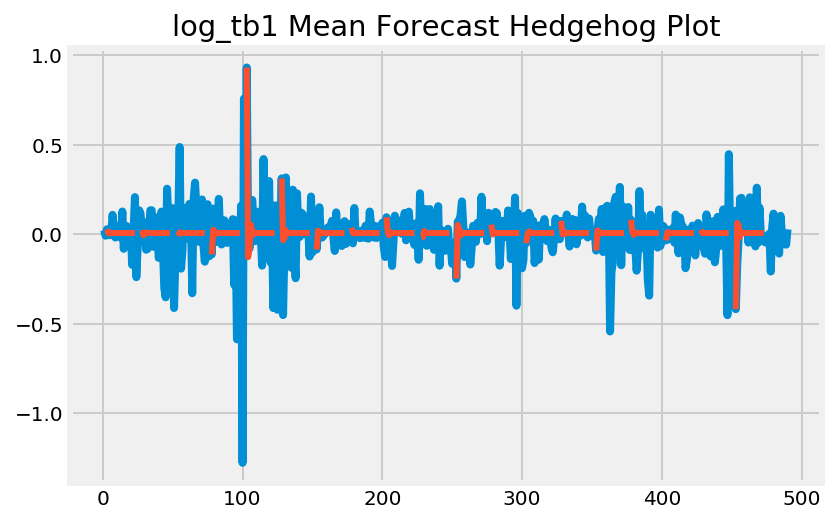

In [15]:
res.hedgehog_plot(horizon=20, step=25, type='mean');

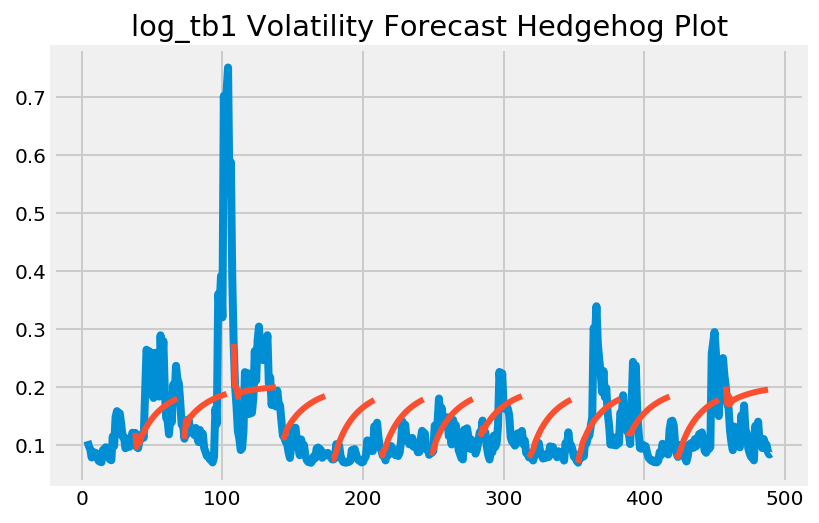

In [16]:
res.hedgehog_plot(horizon=30, step=35, type='volatility');

### Choose variables from the data frame to be regressed on each other. Fit an ARX or GARCH  model taking exogenous variables into account and analyse your model in the same way as above.

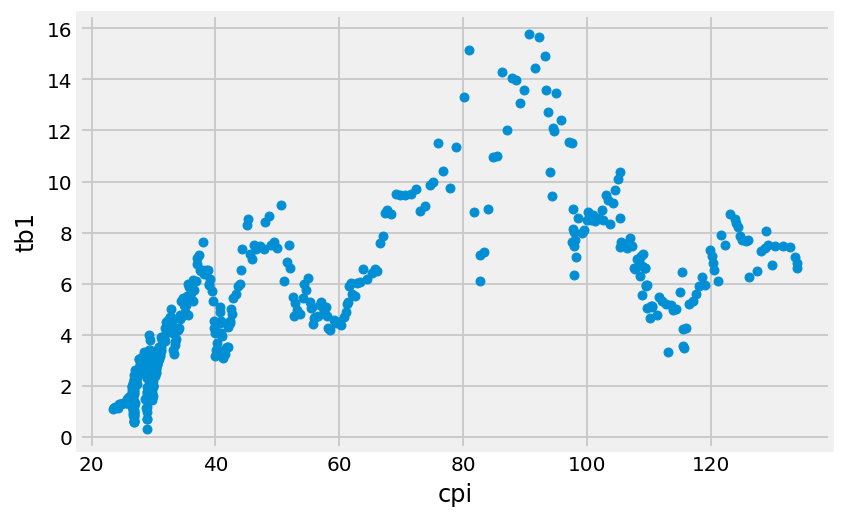

In [17]:
df.plot(kind='scatter',y='tb1',x='cpi');

In [18]:
from arch.univariate import ARX

X = df[['cpi']][1:]
X = (X-X.mean())/X.std()
ar = ARX(data, X, lags = 3, constant=False)
ar.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    AR-X - Constant Variance Model Results                    
==============================================================================
Dep. Variable:                log_tb1   R-squared:                       0.034
Mean Model:                      AR-X   Adj. R-squared:                  0.028
Vol Model:          Constant Variance   Log-Likelihood:                243.022
Distribution:                  Normal   AIC:                          -476.043
Method:            Maximum Likelihood   BIC:                          -455.102
                                        No. Observations:                  487
Date:                Fri, Aug 24 2018   Df Residuals:                      482
Time:                        10:52:50   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
log_tb1[1]     -0.1693  8.506e-02     -1.990  4.659e-02   [ -0.336,-2.559e-03]
log_tb1[2]     -0.0244  6.603e-02     -0.370      0.711      [ -0.154,  0.105]
log_tb1[3]     -0.0752      0.112     -0.669      0.504      [ -0.296,  0.145]
cpi        -4.3294e-03  6.484e-03     -0.668      0.504 [-1.704e-02,8.380e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2         0.0216  4.010e-03      5.382  7.382e-08 [1.372e-02,2.944e-02]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [19]:
am = arch_model(data, x=X, mean='ARX', lags=3, vol='GARCH', p=3, q=3)
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:     14,   Neg. LLF: -330.7743571659605
Iteration:      2,   Func. Count:     33,   Neg. LLF: -331.3058036997612
Iteration:      3,   Func. Count:     50,   Neg. LLF: -333.7972604870946
Iteration:      4,   Func. Count:     69,   Neg. LLF: -333.9189613068681
Iteration:      5,   Func. Count:     84,   Neg. LLF: -342.840936916735
Iteration:      6,   Func. Count:     99,   Neg. LLF: -347.3090713224735
Iteration:      7,   Func. Count:    115,   Neg. LLF: -347.78661071638965
Iteration:      8,   Func. Count:    130,   Neg. LLF: -349.78569769318807
Iteration:      9,   Func. Count:    145,   Neg. LLF: -351.2197440924218
Iteration:     10,   Func. Count:    160,   Neg. LLF: -352.0018650960381
Iteration:     11,   Func. Count:    175,   Neg. LLF: -352.50945010748467
Iteration:     12,   Func. Count:    190,   Neg. LLF: -353.3399579404785
Iteration:     13,   Func. Count:    206,   Neg. LLF: -353.60474816752094
Iteration:     14,   Func. Count:    221,   Neg.

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:                log_tb1   R-squared:                       0.009
Mean Model:                      AR-X   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                354.532
Distribution:                  Normal   AIC:                          -685.063
Method:            Maximum Likelihood   BIC:                          -634.804
                                        No. Observations:                  487
Date:                Fri, Aug 24 2018   Df Residuals:                      475
Time:                        10:52:50   Df Model:                           12
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      8.4085e-03  4.925e-03      1.707  8.776e-02 [-1.244e-03,1.806e-02]
log_tb1[1]    -0.1820  6.119e-02     -2.975  2.934e-03   [ -0.302,-6.208e-02]
log_tb1[2]    -0.1380  5.562e-02     -2.482  1.308e-02   [ -0.247,-2.902e-02]
log_tb1[3] 5.3988e-03  5.764e-02  9.366e-02      0.925      [ -0.108,  0.118]
cpi           -0.0121  6.862e-03     -1.764  7.773e-02 [-2.555e-02,1.345e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.6801e-03  1.535e-03      1.746  8.086e-02 [-3.290e-04,5.689e-03]
alpha[1]       0.2640      0.104      2.528  1.146e-02    [5.936e-02,  0.469]
alpha[2]       0.0809      0.315      0.256      0.798      [ -0.537,  0.699]
alpha[3]       0.2048      0.439      0.467      0.641      [ -0.656,  1.065]
beta[1]        0.3791      0.590      0.643      0.520      [ -0.777,  1.535]
beta[2]        0.0000      1.187      0.000      1.000      [ -2.327,  2.327]
beta[3]        0.0000      0.520      0.000      1.000      [ -1.020,  1.020]
=============================================================================

Covariance estimator: robust
"""

In [20]:
df_1 = pd.read_csv('datasets/CRSPday.csv')
df_1.head()

,year,month,day,ge,ibm,mobil,crsp
0,1989,1,3,-0.016760,0.000000,-0.002747,-0.007619
1,1989,1,4,0.017045,0.005128,0.005510,0.013016
2,1989,1,5,-0.002793,-0.002041,0.005479,0.002815
3,1989,1,6,0.000000,-0.006135,0.002725,0.003064
4,1989,1,9,0.000000,0.004115,0.005435,0.001633


In [21]:
data = df_1[['ge']]
X = df_1[['crsp']]
am = arch_model(data, x=X, mean='ARX', lags=3, vol='GARCH', p=3, q=3)
res = am.fit(options={'maxiter':2000,'ftol':0.0001})
res.summary()

Iteration:      1,   Func. Count:     14,   Neg. LLF: -8212.296938238214
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8212.35260023467
            Iterations: 1
            Function evaluations: 23
            Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:                     ge   R-squared:                       0.516
Mean Model:                      AR-X   Adj. R-squared:                  0.515
Vol Model:                      GARCH   Log-Likelihood:                8212.35
Distribution:                  Normal   AIC:                          -16400.7
Method:            Maximum Likelihood   BIC:                          -16330.7
                                        No. Observations:                 2525
Date:                Fri, Aug 24 2018   Df Residuals:                     2513
Time:                        10:52:50   Df Model:                           12
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const      4.0650e-04  1.760e-04      2.309  2.093e-02   [6.149e-05,7.515e-04]
ge[1]         -0.0596  1.666e-02     -3.578  3.460e-04 [-9.224e-02,-2.695e-02]
ge[2]         -0.0372  1.560e-02     -2.385  1.709e-02 [-6.777e-02,-6.626e-03]
ge[3]         -0.0265  1.509e-02     -1.758  7.879e-02  [-5.608e-02,3.051e-03]
crsp           1.2719  2.905e-02     43.791      0.000       [  1.215,  1.329]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.8209e-06  4.084e-12  4.459e+05      0.000  [1.821e-06,1.821e-06]
alpha[1]       0.0167  1.737e-02      0.960      0.337 [-1.737e-02,5.070e-02]
alpha[2]       0.0167  1.928e-02      0.864      0.387 [-2.113e-02,5.446e-02]
alpha[3]       0.0167  1.361e-02      1.224      0.221 [-1.001e-02,4.335e-02]
beta[1]        0.3100      0.826      0.375      0.707      [ -1.309,  1.929]
beta[2]        0.3100      0.288      1.075      0.282      [ -0.255,  0.875]
beta[3]        0.3100      0.922      0.336      0.737      [ -1.497,  2.117]
=============================================================================

Covariance estimator: robust
"""

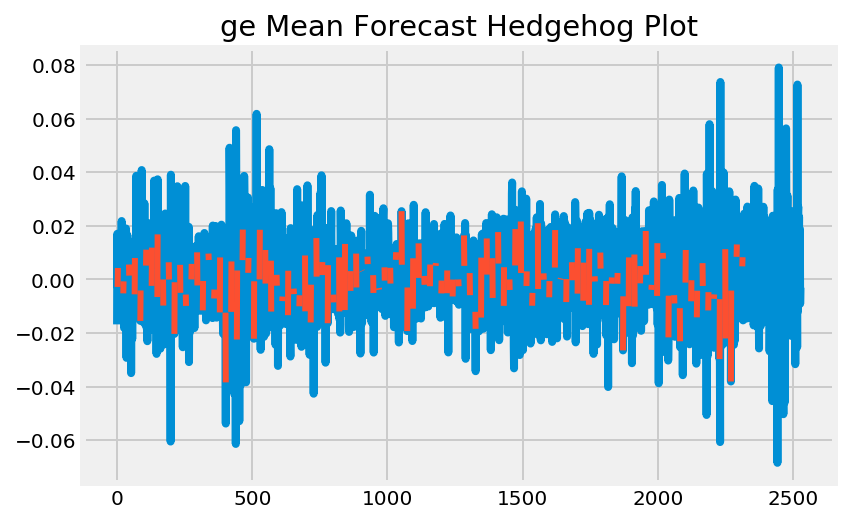

In [22]:
res.hedgehog_plot(horizon=200, step=21, type='mean');

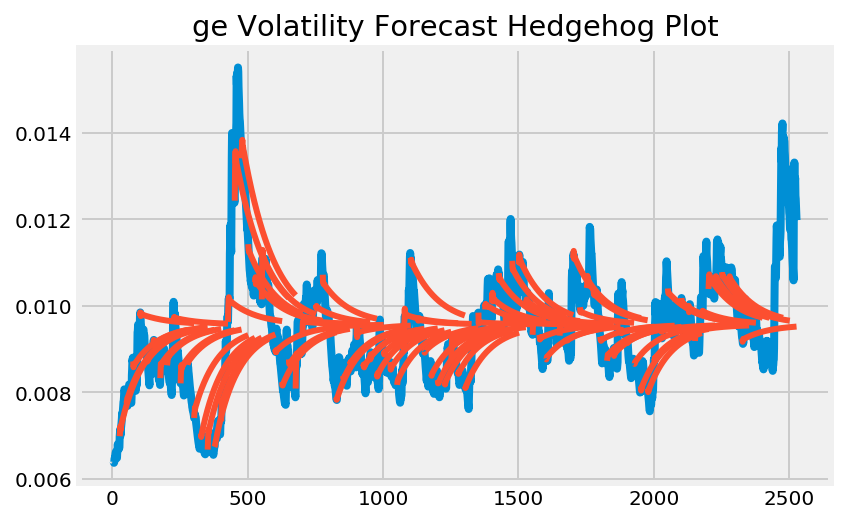

In [23]:
res.hedgehog_plot(horizon=200, step=25, type='volatility');